In [1]:
from google.colab import drive
print("Mounting Google Drive (skip if not needed)...")
try:
    drive.mount('/content/drive')
except Exception as e:
    print('Mount skipped or failed:', e)


Mounting Google Drive (skip if not needed)...
Mount skipped or failed: Error: credential propagation was unsuccessful


In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.19.0


In [3]:
# Configuration
CONFIG = {
    'VOCAB_SIZE': 20000,     # top N words to keep
    'MAXLEN': 200,           # max tokens per sample
    'EMBEDDING_DIM': 100,    # 50/100/200 depending on GloVe you download
    'BATCH_SIZE': 128,
    'EPOCHS': 10,
    'RNN_UNITS': 128,
    'DROPOUT': 0.5,
    'MODEL_DIR': '/content/drive/MyDrive/sentiment_models'
}
os.makedirs(CONFIG['MODEL_DIR'], exist_ok=True)
CONFIG

{'VOCAB_SIZE': 20000,
 'MAXLEN': 200,
 'EMBEDDING_DIM': 100,
 'BATCH_SIZE': 128,
 'EPOCHS': 10,
 'RNN_UNITS': 128,
 'DROPOUT': 0.5,
 'MODEL_DIR': '/content/drive/MyDrive/sentiment_models'}

In [4]:

USE_IMDB = True   # set to False if  want to load your own CSV
CSV_PATH = '/content/drive/MyDrive/your_sentiment_dataset.csv'

if USE_IMDB:
    print('Loading Keras IMDB dataset...')
    VOCAB_SIZE = CONFIG['VOCAB_SIZE']
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=VOCAB_SIZE)
    x_train = pad_sequences(x_train, maxlen=CONFIG['MAXLEN'], padding='post', truncating='post')
    x_test = pad_sequences(x_test, maxlen=CONFIG['MAXLEN'], padding='post', truncating='post')
    print('train shape:', x_train.shape, 'test shape:', x_test.shape)

    word_index = tf.keras.datasets.imdb.get_word_index()
    index_word = {v+3:k for k,v in word_index.items()}
    index_word[0] = '<PAD>'
    index_word[1] = '<START>'
    index_word[2] = '<UNK>'
    index_word[3] = '<UNUSED>'
else:
    print('Loading CSV dataset from:', CSV_PATH)
    df = pd.read_csv(CSV_PATH)
    assert 'text' in df.columns and 'label' in df.columns, 'CSV must contain text and label columns'
    df['text'] = df['text'].astype(str)
    df['label'] = df['label'].astype(int)
    train_texts, test_texts, y_train, y_test = train_test_split(df['text'].values, df['label'].values, test_size=0.2, random_state=42)
    tokenizer = Tokenizer(num_words=CONFIG['VOCAB_SIZE'], oov_token='<OOV>')
    tokenizer.fit_on_texts(train_texts)
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_train = pad_sequences(x_train, maxlen=CONFIG['MAXLEN'], padding='post', truncating='post')
    x_test = tokenizer.texts_to_sequences(test_texts)
    x_test = pad_sequences(x_test, maxlen=CONFIG['MAXLEN'], padding='post', truncating='post')
    print('train shape:', x_train.shape, 'test shape:', x_test.shape)


Loading Keras IMDB dataset...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
train shape: (25000, 200) test shape: (25000, 200)
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
USE_GLOVE = False
embedding_matrix = None
if USE_GLOVE:
    !wget -q http://nlp.stanford.edu/data/glove.6B.zip -O glove.6B.zip
    !unzip -q glove.6B.zip -d glove.6B
    glove_path = '/content/glove.6B/glove.6B.100d.txt'
    EMBEDDING_DIM = CONFIG['EMBEDDING_DIM']
    embedding_index = {}
    with open(glove_path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coeffs = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = coeffs
    print('Found %d word vectors.' % len(embedding_index))
    vocab_size = CONFIG['VOCAB_SIZE']
    embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    if USE_IMDB:
        for word, i in word_index.items():
            if i < vocab_size:
                embedding_vector = embedding_index.get(word)
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
    else:
        word_index_local = tokenizer.word_index
        for word, i in word_index_local.items():
            if i < vocab_size:
                embedding_vector = embedding_index.get(word)
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector


In [6]:
from tensorflow.keras import layers, Model

def build_rnn_model(rnn_type='LSTM', vocab_size=CONFIG['VOCAB_SIZE'], embedding_dim=CONFIG['EMBEDDING_DIM'], maxlen=CONFIG['MAXLEN'],
                    rnn_units=CONFIG['RNN_UNITS'], dropout=CONFIG['DROPOUT'], embedding_matrix=None, bidirectional=False):
    inputs = layers.Input(shape=(maxlen, ), dtype='int32')
    if embedding_matrix is not None:
        emb = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False)(inputs)
    else:
        emb = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen)(inputs)
    x = layers.SpatialDropout1D(0.2)(emb)
    if rnn_type.upper() == 'LSTM':
        core = layers.LSTM(rnn_units, return_sequences=False)
    elif rnn_type.upper() == 'GRU':
        core = layers.GRU(rnn_units, return_sequences=False)
    else:
        raise ValueError('rnn_type must be either LSTM or GRU')
    if bidirectional:
        x = layers.Bidirectional(core)(x)
    else:
        x = core(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Quick model summary example
model = build_rnn_model(rnn_type='LSTM', embedding_matrix=embedding_matrix, bidirectional=True)
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 200, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,251,009 (8.59 MB)

 Trainable params: 2,251,009 (8.59 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    ModelCheckpoint(os.path.join(CONFIG['MODEL_DIR'], 'best_model.h5'), save_best_only=True, monitor='val_loss')
]
callbacks


In [8]:
history = model.fit(
    x_train, y_train,
    epochs=CONFIG['EPOCHS'],
    batch_size=CONFIG['BATCH_SIZE'],
    validation_split=0.1,
    callbacks=callbacks
)


Epoch 1/10
175/176 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6161 - loss: 0.6192

176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.6174 - loss: 0.6181 - val_accuracy: 0.8492 - val_loss: 0.3702 - learning_rate: 0.0010
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.8909 - loss: 0.2949 - val_accuracy: 0.8596 - val_loss: 0.3851 - learning_rate: 0.0010
Epoch 3/10
175/176 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9294 - loss: 0.2083

176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9293 - loss: 0.2083 - val_accuracy: 0.8708 - val_loss: 0.3481 - learning_rate: 0.0010
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9536 - loss: 0.1421 - val_accuracy: 0.8656 - val_loss: 0.4003 - learning_rate: 0.0010
Epoch 5/10
175/176 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9674 - loss: 0.1064
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9674 - loss: 0.1065 - val_accuracy: 0.8596 - val_loss: 0.4055 - learning_rate: 0.0010
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9795 - loss: 0.0622 - val_accuracy: 0.8576 - val_loss: 0.5757 - learning_rate: 5.0000e-04


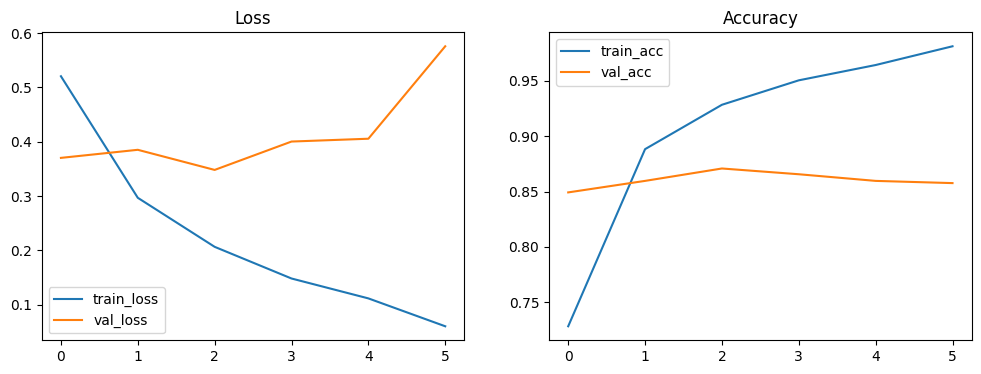

In [9]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy')
plt.show()


196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
Accuracy: 0.838

Classification report:
              precision    recall  f1-score   support

           0     0.8207    0.8650    0.8423     12500
           1     0.8573    0.8110    0.8335     12500

    accuracy                         0.8380     25000
   macro avg     0.8390    0.8380    0.8379     25000
weighted avg     0.8390    0.8380    0.8379     25000

Confusion matrix:
 [[10813  1687]
 [ 2363 10137]]


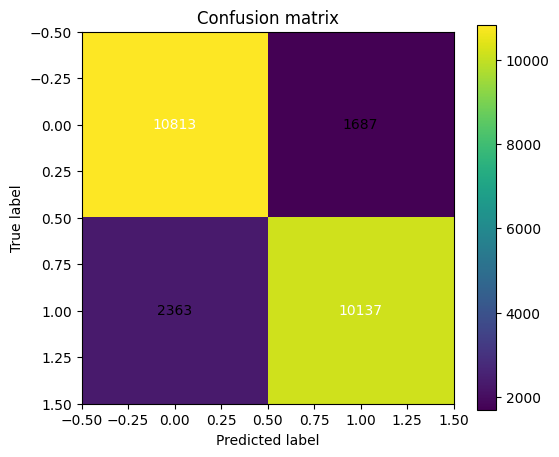

In [10]:
# Predict
y_pred_probs = model.predict(x_test, batch_size=CONFIG['BATCH_SIZE'])
y_pred = (y_pred_probs.flatten() >= 0.5).astype(int)
print('Accuracy:', np.mean(y_pred == y_test))
print('\nClassification report:')
print(classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', cm)
# Plot confusion matrix
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.max()/2 else 'black')
plt.show()


In [11]:
import pickle
TOKENIZER_PATH = os.path.join(CONFIG['MODEL_DIR'], 'tokenizer.pickle')
MODEL_PATH = os.path.join(CONFIG['MODEL_DIR'], 'final_model.h5')
try:
    if not USE_IMDB:
        with open(TOKENIZER_PATH, 'wb') as f:
            pickle.dump(tokenizer, f)
        print('Tokenizer saved to', TOKENIZER_PATH)
    else:
        with open(os.path.join(CONFIG['MODEL_DIR'], 'imdb_index_word.pickle'), 'wb') as f:
            pickle.dump(index_word, f)
        print('IMDB index_word saved')
    model.save(MODEL_PATH)
    print('Model saved to', MODEL_PATH)
except Exception as e:
    print('Save failed:', e)


IMDB index_word saved
Model saved to /content/drive/MyDrive/sentiment_models/final_model.h5


In [23]:
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer



def predict_text_sentiment(text, model, tokenizer=None, index_word=None, maxlen=CONFIG['MAXLEN']):
    def clean_text(s):
        s = s.lower()
        s = re.sub(r'<.*?>', ' ', s)
        s = re.sub(r"[^a-z0-9\s]", ' ', s)
        s = re.sub(r"\s+", ' ', s).strip()
        return s

    text_clean = clean_text(text)
    if USE_IMDB:

        seq = []
        for word in text_clean.split():
            seq.append(word_index.get(word, 2))
        seq = [seq]
    else:

        seq = tokenizer.texts_to_sequences([text_clean])

    pad = pad_sequences(seq, maxlen=maxlen, padding='post', truncating='post')
    prob = model.predict(pad)[0][0]
    label = 'positive' if prob >= 0.5 else 'negative'
    return {'probability': float(prob), 'label': label}

# 🔹 Test predictions
samples = [
    "I love this movie. It's fantastic and well-paced.",
    "This film was terrible, I hated every minute.",
    "It was okay, not great but not bad either.",
    "It was bad."
]

for s in samples:
    print(s, "->", predict_text_sentiment(s, model, tokenizer if not USE_IMDB else None, index_word if USE_IMDB else None))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
I love this movie. It's fantastic and well-paced. -> {'probability': 0.7136836051940918, 'label': 'positive'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
This film was terrible, I hated every minute. -> {'probability': 0.6107036471366882, 'label': 'positive'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
It was okay, not great but not bad either. -> {'probability': 0.7312169671058655, 'label': 'positive'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
It was bad. -> {'probability': 0.19296737015247345, 'label': 'negative'}
